# lastfm-360k data_analysis

In [64]:
# Step 1: 导入库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Step 2: 读取 RecBole 的 atomic 文件
user_df = pd.read_csv('atomic_datasets/lastfm-360k/lastfm-360k.user', sep='\t')
inter_df = pd.read_csv('atomic_datasets/lastfm-360k/lastfm-360k.inter', sep='\t')

print(user_df.nunique())
print(inter_df.nunique())
print(f"Before removing duplicates: {inter_df.shape}")

user_id:token    359347
gender:token          2
age:float           113
country:token       239
dtype: int64
user_id:token      359349
artist_id:token    160167
plays:float         14168
dtype: int64
Before removing duplicates: (17559530, 3)


In [65]:
# aggregate plays for duplicate user-item pairs
inter_df_agg = inter_df.groupby(['user_id:token', 'artist_id:token'], as_index=False)['plays:float'].sum()

print(f"After aggregation: {inter_df_agg.shape}")

After aggregation: (17332710, 3)


In [66]:
user_df = user_df[user_df['user_id:token'].isin(inter_df_agg['user_id:token'])]
filtered_user_df = user_df[user_df['gender:token'].notna()]

print(f"After removing users without gender: {filtered_user_df.shape}")

valid_user_ids = set(filtered_user_df['user_id:token'])
filtered_inter_df = inter_df_agg[inter_df_agg['user_id:token'].isin(valid_user_ids)]
print(f"After filtering interactions: {filtered_inter_df.shape}")

After removing users without gender: (326565, 4)
After filtering interactions: (15763764, 3)


In [77]:
#normalize plays for each user
filtered_inter_df.loc[:, 'plays_user_norm:float'] = filtered_inter_df.groupby('user_id:token')['plays:float'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1.0
)

In [68]:
filtered_inter_df.to_csv('gender_norm/lastfm-360k/lastfm-360k.inter', sep='\t',index=False)
print("Filtered interaction data written to 'lastfm-360k.inter'")

filtered_user_df.to_csv('gender_norm/lastfm-360k/lastfm-360k.user',sep='\t',index=False)
print("Filtered user data written to 'lastfm-360k.user'")

Filtered interaction data written to 'lastfm-360k.inter'
Filtered user data written to 'lastfm-360k.user'


# analyze the filtered data

In [69]:
user_df = pd.read_csv('gender_norm/lastfm-360k/lastfm-360k.user', sep='\t')
inter_df = pd.read_csv('gender_norm/lastfm-360k/lastfm-360k.inter', sep='\t')

print(user_df.nunique())
print(inter_df.nunique())
print(inter_df.shape)

user_id:token    326565
gender:token          2
age:float           111
country:token       239
dtype: int64
user_id:token             326565
artist_id:token           155486
plays:float                13758
plays_user_norm:float    1557985
dtype: int64
(15763764, 4)


In [70]:
n_users = inter_df['user_id:token'].nunique()
n_items = inter_df['artist_id:token'].nunique()
n_interactions = inter_df.shape[0]
sparsity = 1 - (n_interactions / (n_users * n_items))
print(f"Dataset Sparsity: {sparsity:.4%}")

Dataset Sparsity: 99.9690%


In [71]:
print("User Data:")
display(user_df.head())
print("Interaction Data:")
display(inter_df.head())

User Data:


,user_id:token,gender:token,age:float,country:token
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada
2,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico
3,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States
4,0000c176103e538d5c9828e695fed4f7ae42dd01,m,20.0,United Kingdom


Interaction Data:


,user_id:token,artist_id:token,plays:float,plays_user_norm:float
0,00000c289a1829a808ac09c00daf10bc3c4e223b,0639533a-0402-40ba-b6e0-18b067198b73,403,0.135593
1,00000c289a1829a808ac09c00daf10bc3c4e223b,0fb62639-4143-443b-8779-6867a1d08230,183,0.025922
2,00000c289a1829a808ac09c00daf10bc3c4e223b,144ef525-85e9-40c3-8335-02c32d0861f3,182,0.025424
3,00000c289a1829a808ac09c00daf10bc3c4e223b,21f3573f-10cf-44b3-aeaa-26cccd8448b5,507,0.187438
4,00000c289a1829a808ac09c00daf10bc3c4e223b,295a3ae3-9e81-4cff-a36f-8d48b8fb4dcf,288,0.078265


## 1. user_df data analysis

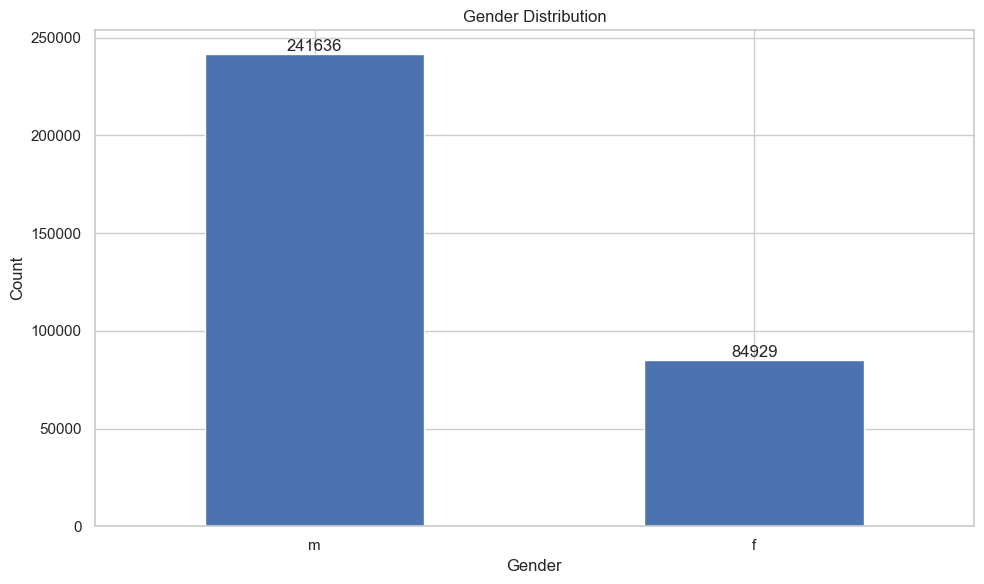

In [72]:
# gender distribution
gender_counts = user_df['gender:token'].value_counts()

# 绘制柱状图
ax = gender_counts.plot(kind='bar', title='Gender Distribution', rot=0)

# 添加每个柱子的数值标签
for i, count in enumerate(gender_counts):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

# 展示图形
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

User Activity Statistics:
         total_plays
count  326565.000000
mean    10545.054320
std     14656.412958
min         1.000000
25%      2452.000000
50%      6204.000000
75%     13192.000000
max    779462.000000


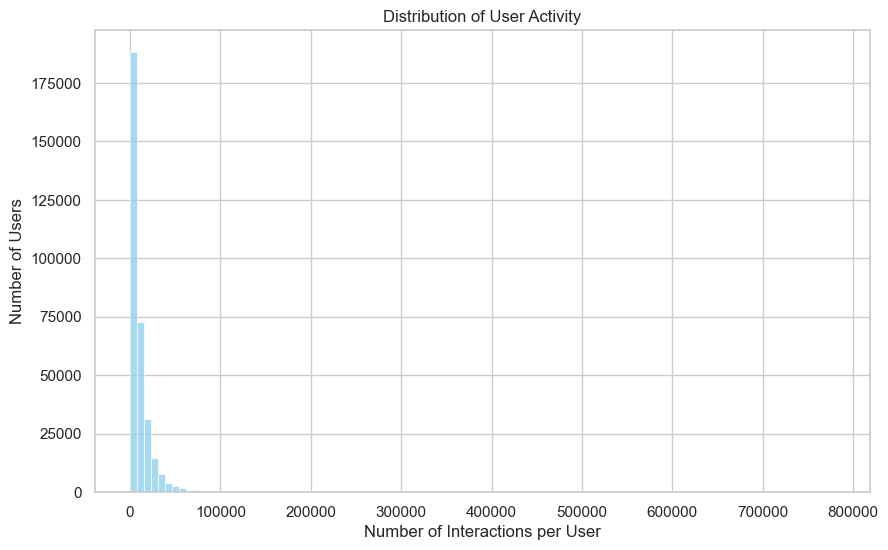

In [73]:
# user activity distribution plays
user_activity = inter_df.groupby('user_id:token')['plays:float'].sum().reset_index()

print("User Activity Statistics:")
user_activity.columns = ['user_id', 'total_plays']
print(user_activity.describe())

plt.figure(figsize=(10, 6))
sns.histplot(user_activity['total_plays'], bins=100, kde=False, color='skyblue')
plt.title("Distribution of User Activity")
plt.xlabel("Number of Interactions per User")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

User Activity Statistics:
       total_plays_norm
count     326565.000000
mean           7.829227
std            3.521296
min            1.000000
25%            5.277466
50%            7.402004
75%            9.862637
max          105.000000


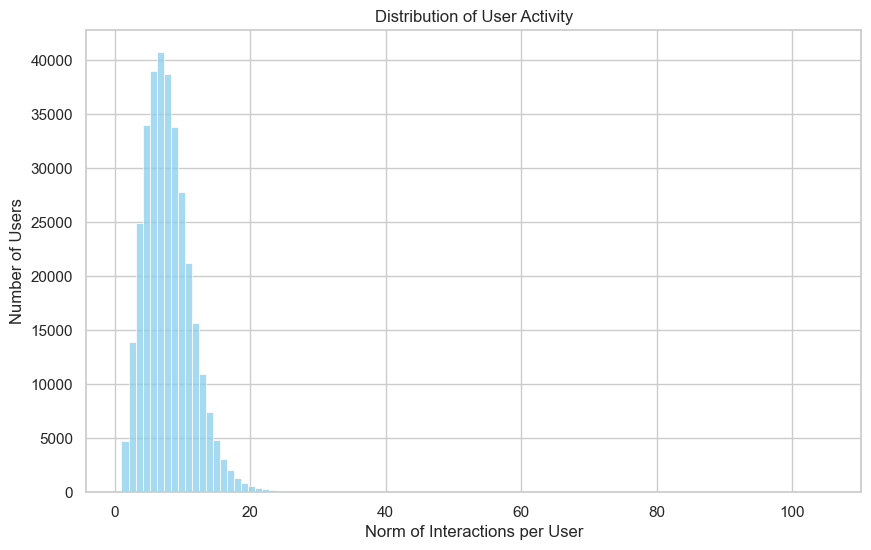

In [80]:
# user activity distribution plays_user_norm
user_activity = inter_df.groupby('user_id:token')['plays_user_norm:float'].sum().reset_index()

print("User Activity Statistics:")
user_activity.columns = ['user_id', 'total_plays_norm']
print(user_activity.describe())

plt.figure(figsize=(10, 6))
sns.histplot(user_activity['total_plays_norm'], bins=100, kde=False, color='skyblue')
plt.title("Distribution of User Activity")
plt.xlabel("Norm of Interactions per User")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

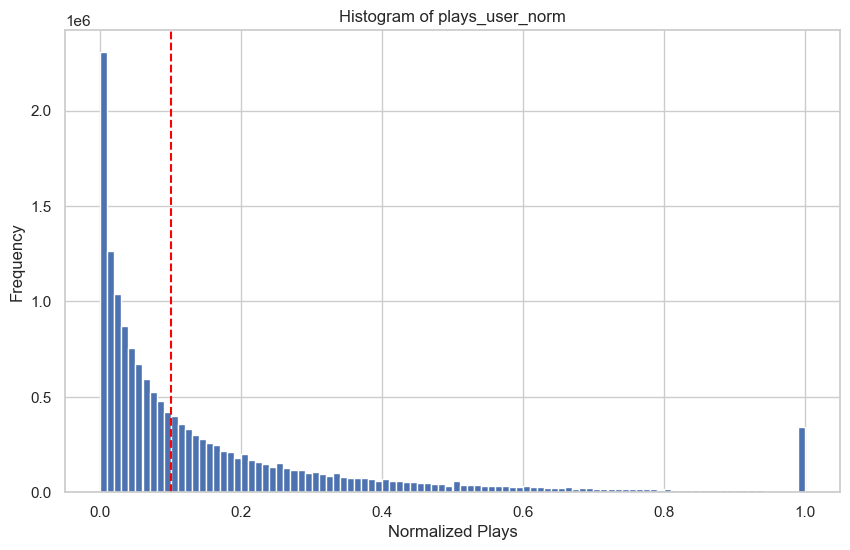

In [85]:
plt.hist(inter_df['plays_user_norm:float'], bins=100)
plt.axvline(x=0.1, color='red', linestyle='--')
plt.title("Histogram of plays_user_norm")
plt.xlabel("Normalized Plays")
plt.ylabel("Frequency")
plt.show()

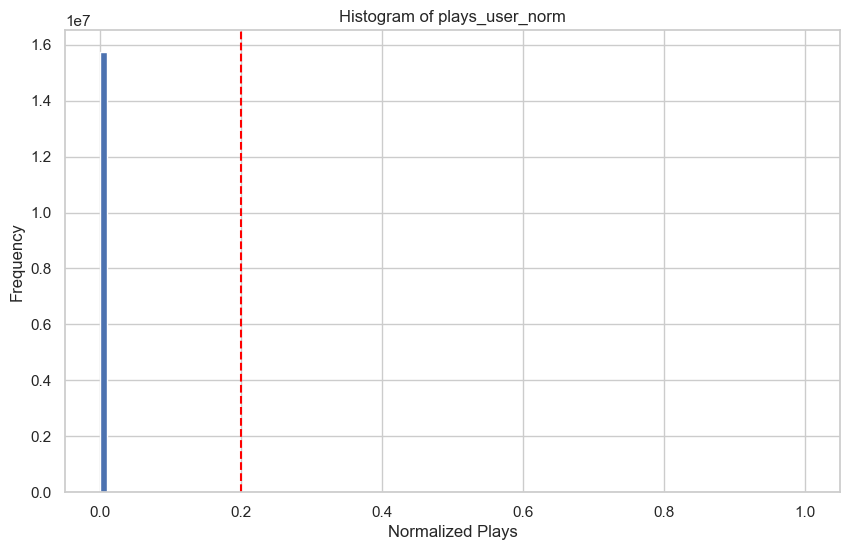

In [84]:
min_play = inter_df['plays:float'].min()
max_play = inter_df['plays:float'].max()
inter_df.loc[:, 'plays_norm:float'] = (inter_df['plays:float'] - min_play) / (max_play - min_play)

plt.hist(inter_df['plays_norm:float'], bins=100)
plt.axvline(x=0.2, color='red', linestyle='--')
plt.title("Histogram of plays_user_norm")
plt.xlabel("Normalized Plays")
plt.ylabel("Frequency")
plt.show()

Item Popularity Statistics:
count    155486.000000
mean        101.383816
std         840.010923
min           1.000000
25%           2.000000
50%           5.000000
75%          23.000000
max       70126.000000
Name: count, dtype: float64


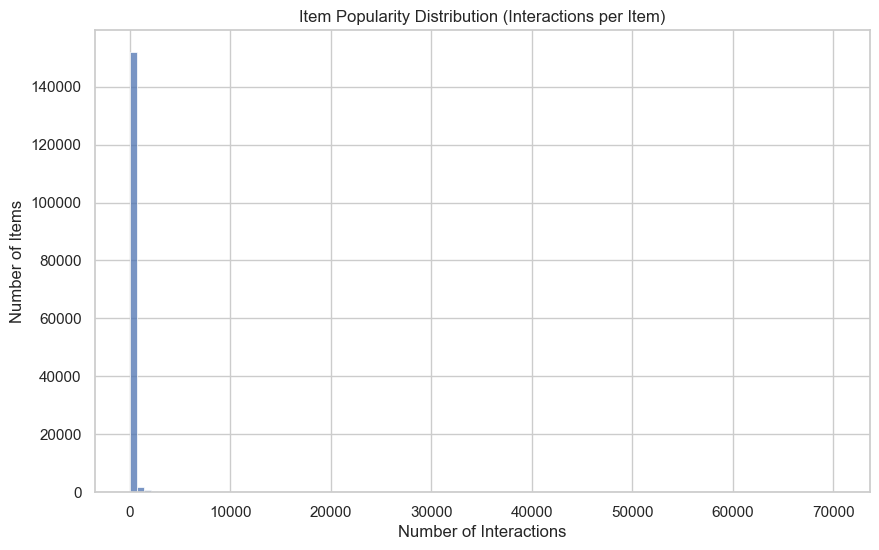

In [75]:
item_popularity = inter_df['artist_id:token'].value_counts()
print("Item Popularity Statistics:")
print(item_popularity.describe())

sns.histplot(item_popularity, bins=100, kde=False)
plt.title('Item Popularity Distribution (Interactions per Item)')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Items')
plt.show() 

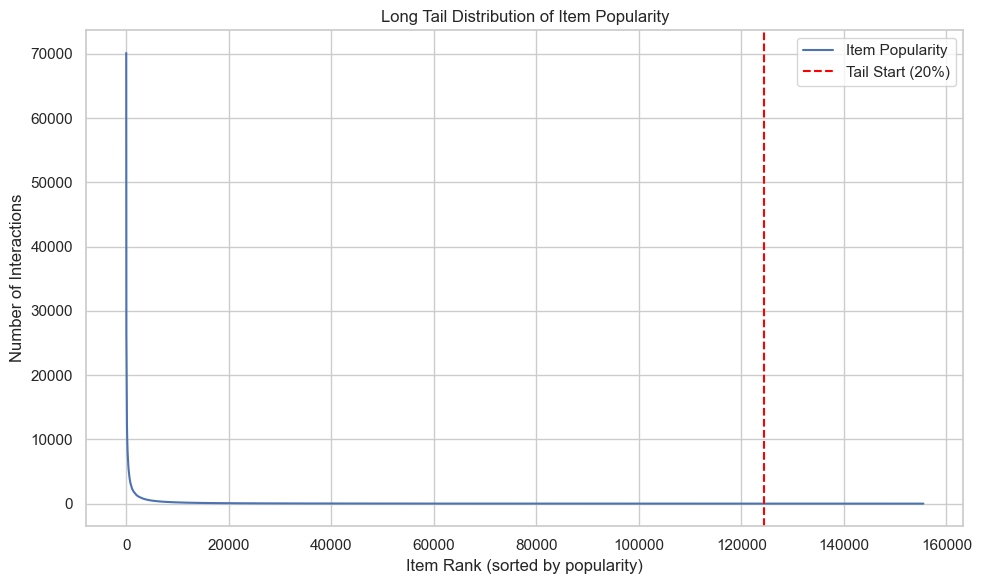

In [76]:
# Calculate item popularity
item_popularity = inter_df['artist_id:token'].value_counts()

# Sort popularity in descending order
sorted_popularity = item_popularity.sort_values(ascending=False).reset_index(drop=True)

tail_ratio = 0.2
tail_index = int(len(sorted_popularity) * (1 - tail_ratio))

# Plot: Long-tail with tail cutoff
plt.figure(figsize=(10, 6))
plt.plot(sorted_popularity.values, label='Item Popularity')
plt.axvline(x=tail_index, color='red', linestyle='--', label=f'Tail Start ({int(tail_ratio*100)}%)')
plt.title('Long Tail Distribution of Item Popularity')
plt.xlabel('Item Rank (sorted by popularity)')
plt.ylabel('Number of Interactions')
#plt.yscale('log')  # Optional: log scale for better visibility of tail
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()